In [138]:
import numpy as np
import numpy.ma as ma
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from math import e
from math import pi
from math import sqrt
from astropy.table import Column
from scipy.optimize import curve_fit
import scipy.optimize as opt
import statsmodels.api as sm

In [139]:
classes=Table.read('lgcs-m33-v2_classes-Copy1.fits')
print("Classes: ", classes.colnames)
subjects=Table.read('lgcs-m33-v2_subjects-wmeta-Copy1.fits')
print("Subjects: ",subjects.colnames)
markings=Table.read('lgcs-m33-v2_markings-Copy1.fits')
print("Markings: ",markings.colnames)
objects=Table.read('f2_napcan_gridbest.fits')
print("Objects: ", objects.colnames)
marks_for_objects=Table.read('f2_cdata-Copy1.fits')
print("Marks_for_objects:", marks_for_objects.colnames)
Final_Table=Table.read('Final_Table.fits')
print("Final_Table:", Final_Table.colnames)
Syns=Table.read('synclst_lgcs-m33-Copy1.fits')
print("Syns:", Syns.colnames)
gb_si=Table.read('Syntetic_table.fits')
print("Synthetic_table:", gb_si.colnames)

Classes:  ['classification_id', 'user_name', 'user_id', 'user_ip', 'workflow_id', 'workflow_version', 'created_at', 'subject_ids', 'n_markings']
Subjects:  ['SUBJECT_ID', 'PROJECT_ID', 'WORKFLOW_ID', 'SUBJECT_SET_ID', 'SUBIMG', 'BRICK', 'FIELD', 'IMG', 'TOOTH', 'SYNTHETIC', 'SYNFLD', 'CLASSIFICATION_COUNT']
Markings:  ['classification_id', 'user_name', 'user_id', 'subject_ids', 'tool', 'tool_label', 'x', 'y', 'r', 'frame']
Objects:  ['ID', 'SUBJECT_ID', 'CLASSIFICATION_COUNT', 'NEWCLSTFRAC', 'E_NEWCLSTFRAC', 'NEWCLASSCOUNT', 'TOT_D_WEIGHT', 'TOT_NOND_WEIGHT']
Marks_for_objects: ['CLASSIFICATION_ID', 'USER_NAME', 'USER_ID', 'SUBJECT_IDS', 'TOOL', 'TOOL_LABEL', 'X', 'Y', 'R', 'FRAME', 'CANID', 'CANTYPE']
Final_Table: ['Users', 'Num_of_Class', 'Num_of_Im_w/GC_Viewed', 'Total_GC_Viewed', 'Total_GC_Found', 'Percent_Accuracy', 'Average_CFRAC']
Syns: ['SYNID', 'SUBIMG', 'BRICK', 'FIELD', 'IMG', 'NMS', 'NRGB', 'SYN_NUM', 'SYN_FILENAME', 'LOGAGE', 'MASSIN', 'MASSOUT', 'F475TOT', 'F814TOT', 'RCO

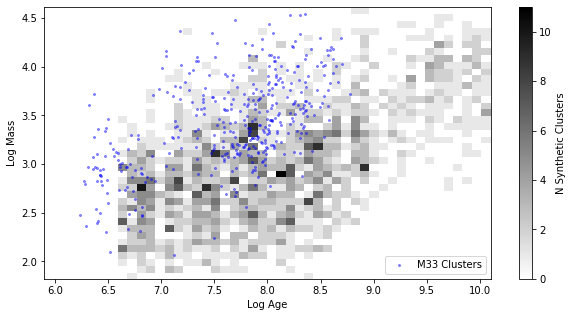

In [140]:
#read in M33 cat:

cat=Table.read('M33_Cat_with_Subselections.fits')
ind=np.where((cat['Age_50']< 15) & (cat['VIEWFRAC']*cat['CFRAC'] >= .5))
use=cat[ind]

#Create a 2D Hist of the Synthetic coverage with the BF cluster props plotted on top
fig=plt.figure(figsize=(10,5))
plt.hist2d(gb_si['LOGAGE'], np.log10(gb_si['MASSOUT']), bins=40, cmap='gray_r', label='Synthetic Clusters')
plt.colorbar(label='N Synthetic Clusters')
plt.scatter(use['Age_50'], use['Mass_50'], color='b', s=4, alpha=.4, label='M33 Clusters')
plt.xlabel('Log Age')
plt.ylabel('Log Mass')
plt.xlim(5.9, 10.1)
plt.legend(loc=4)
plt.show()

In [141]:
high_av_ind=np.where(gb_si['AV'] > 1.5)
gb_si.remove_rows([high_av_ind])
bye_high_av=gb_si

f=np.where(bye_high_av['WEIGHTED_DETECTED_.674']==True)
nf=np.where(bye_high_av['WEIGHTED_DETECTED_.674']==False)

ND=bye_high_av[nf]
D=bye_high_av[f]

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/astropy/table/table.py:2287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


Text(0, 0.5, 'log Mass')

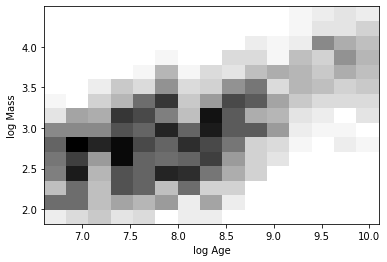

In [142]:
bin_size=15

tot,xedges_mass,yedges_mass,im=plt.hist2d(gb_si['LOGAGE'], np.log10(gb_si['MASSOUT']), bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
plt.xlabel('log Age')
plt.ylabel('log Mass')

Text(0, 0.5, 'log Mass')

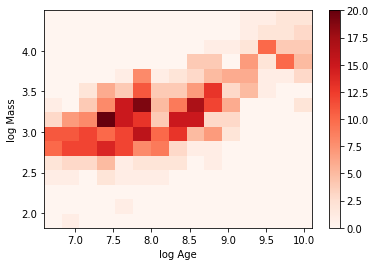

In [143]:
f,_,_,_=plt.hist2d(D['LOGAGE'], np.log10(D['MASSOUT']), bins=[xedges_mass, yedges_mass], cmap='Reds', label='Synthetic Clusters')
plt.colorbar()
plt.xlabel('log Age')
plt.ylabel('log Mass')

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)


Text(0, 0.5, 'log Mass')

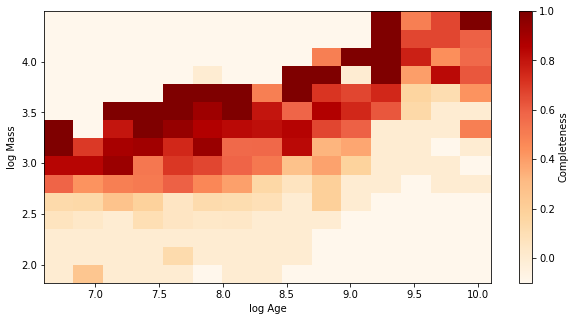

In [144]:
import statsmodels as sm
com=np.array(f/tot)

where_zeros=np.where(f == 0)
f[where_zeros] = 1

err=np.zeros((len(f), len(f)))
for i in range(len(f)):
    for j in range(len(f)):
        err[i][j]=(sm.stats.proportion.proportion_confint(f[i][j], tot[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f[i][j], tot[i][j], alpha=.34, method='agresti_coull')[0])/2

where_are_NaNs = np.isnan(com)
where_are_inf = np.isinf(com)
com[where_are_NaNs] = -.1
com[where_are_inf] = -.1
err[where_are_NaNs]= -.1
err[where_are_inf]= -.1

fig=plt.figure(figsize=(10,5))
plt.pcolormesh(xedges_mass,yedges_mass,com.T,cmap="OrRd")
plt.colorbar(label='Completeness')
plt.xlabel('log Age')
plt.ylabel('log Mass')

In [295]:
#Needed Functions:

def gen_logistic_func(x, x0, k):
    #Current configuration: 2-parameter model, Q=nu=1
    
    A=0
    B=1
    C=1
    Q=1
    nu=1

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def forced_slope_gen_logistic_func(x, x0):
    #Current configuration: 2-parameter model, Q=nu=1
    
    #.674_thresh_k=6.2295
    #.568_thresh_K=5.83
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    k=6.2980

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def linear_poly1(x,a,b):
    return a*x+b
    

    #popt_50fit, pcov_50fit= curve_fit(linear_poly1, x,y)

def completeness(linear_poly1, x, y):
    xs = np.linspace(18.9, 20.1, 100)
    popt_50fit, pcov_50fit = curve_fit(linear_poly1, x, y)
    line = np.poly1d(popt_50fit)

    return ((.5-popt_50fit[1])/(popt_50fit[0]))

def exponential(tau,a,b,c):
    y= a*np.exp(b*(tau-6.71))+c
    return y

def new_log_func(x, age, a, b, c):
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    k=6.2980
    
    x0 = exponential(age, a, b, c)

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def get_model(masses, ages, a, b, c):

    maybe=np.zeros((len(ages), len(masses) ))

    for i in range((len(ages))):
        maybe[i]= new_log_func(masses, ages[i], a, b, c)
    
    return maybe

def lnlike(theta, masses, ages, com, err):
    a, b, c = theta
    
    model=get_model(masses, ages, a, b, c)

    
    fc_com=com[:-1]
    fc_model=model.astype('float32')
    fc_err=err[:-1]
    
    where_data = np.where(fc_com != -.1)
    
    use_com=fc_com[where_data]
    use_model=fc_model[where_data]
    use_err=fc_err[where_data]
    
    chi2= ((use_com-use_model)**2) / (use_err**2)

    return np.sum( -chi2 - 2)

def forced_slope_gen_logistic_func_f475(x, x0):
    #Current configuration: 2-parameter model, Q=nu=1
    
    #.674_thresh_k=-2.39
    #.568_thresh_k=-2.67
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    k=-2.5169

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def exponential_475(tau,a,b,c):
    y= a*np.exp(b*(tau-6.71))+c
    return y

def new_log_func_F475(x, age, a, b, c):
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    k=-2.5169
    
    x0 = exponential(age, a, b, c)

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def get_model_F475(mags, ages, a, b, c):

    maybe=np.zeros((len(ages), len(mags) ))

    for i in range((len(ages))):
        maybe[i]= new_log_func_F475(mags, ages[i], a, b, c)
    
    return maybe

def lnlike_F475(theta, mags, ages, com, err):
    a, b, c = theta
    
    model=get_model_F475(mags, ages, a, b, c)

    
    fc_com=com[:-1]
    fc_model=model.astype('float32')
    fc_err=err[:-1]
    
    where_data = np.where(fc_com != -.1)
    
    use_com=fc_com[where_data]
    use_model=fc_model[where_data]
    use_err=fc_err[where_data]
    
    chi2= ((use_com-use_model)**2) / (use_err**2)

    return np.sum( -chi2 - 2)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

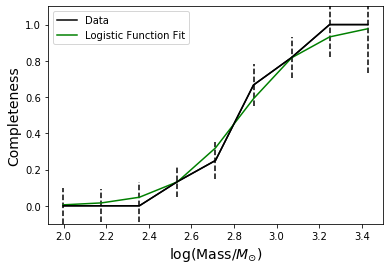

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


[2.83211922]
2.7953696085702253


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


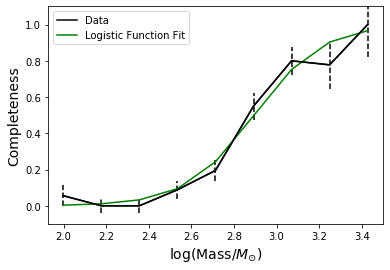

[2.89424145]
2.863872951777153


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

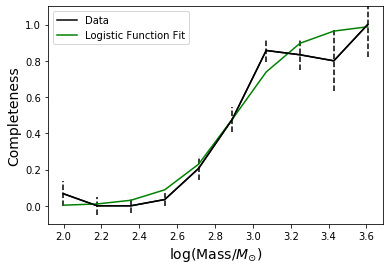

[2.90680133]
2.904720860461257


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

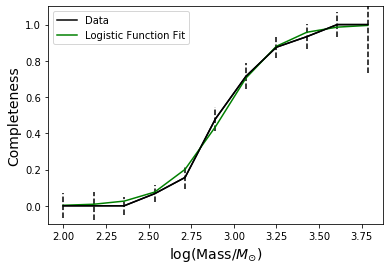

[2.9342596]
2.927017658728917


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

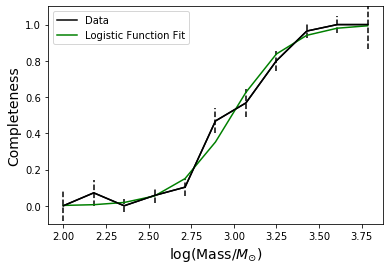

[2.98835964]
2.9537151710325706


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

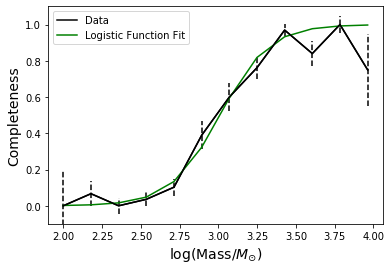

[3.00858481]
3.051434083938436


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

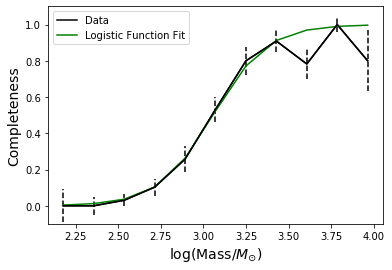

[3.05484433]
3.111760853328182


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

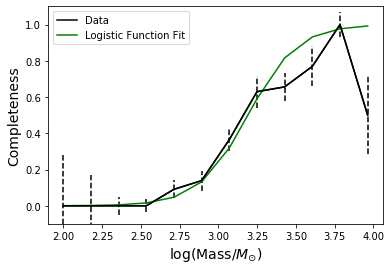

[3.1897338]
3.2961054757760566


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

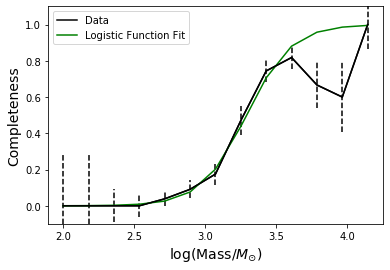

[3.29033028]
3.3685086908162796


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

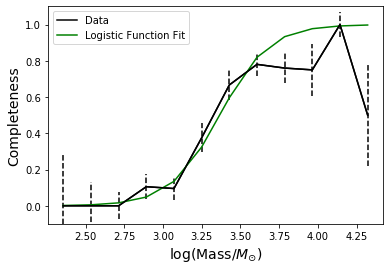

[3.36473939]
3.5007852865669


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

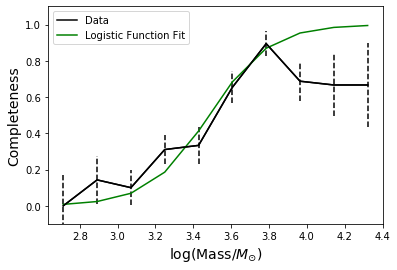

[3.48537676]
3.626329467793879


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

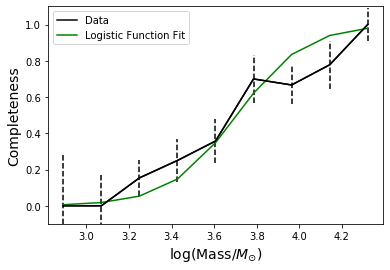

[3.70577836]
3.697061910352187


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

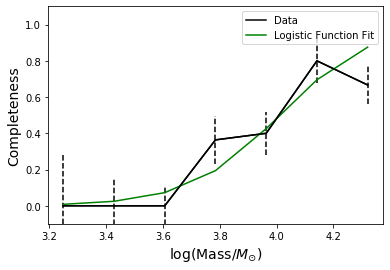

[4.01292587]
4.011800500505873


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

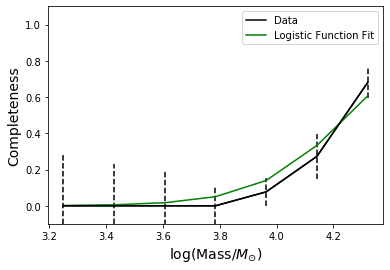

[4.25153219]
4.447942491625622


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

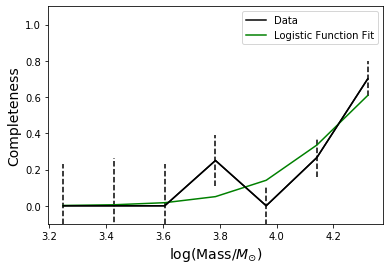

[4.2498792]
4.404514067266055


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional i

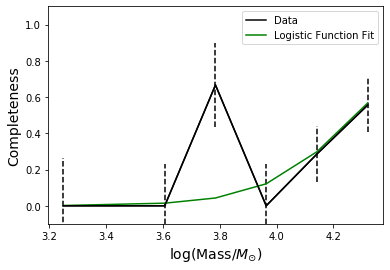

[4.27636516]
4.441750823239366


LogAge_Bin_Min,LogAge_Bin_Med,LogAge_Bin_Max,LF_Fit_X0,LF_Fit_k,50%_Comp,50%_Comp_M2,LF_Values [15]
float64,float64,float64,float64,float64,float64,float64,float64
6.599883079528809,6.833248901367187,7.066614723205566,2.8940327337270335,7.355203028154797,2.8942414514753785,2.863872951777153,0.0011547615656248096 .. 0.9998748848652298
6.833248901367187,7.066614723205566,7.299980545043946,2.9056966048757835,8.372966297179481,2.9068013300271853,2.904720860461257,0.0010730623990226633 .. 0.9998653493138248
7.066614723205566,7.299980545043946,7.533346366882324,2.932511476494003,6.695492697841527,2.9342596008817554,2.927017658728917,0.000906470593567261 .. 0.9998405804822107
7.299980545043946,7.533346366882324,7.766712188720703,2.9887379691076306,6.3665195508127015,2.9883596441479674,2.9537151710325706,0.0006363282143902546 .. 0.9997728556049664
7.533346366882324,7.766712188720703,8.000078010559083,3.009893626079044,6.491481879850841,3.0085848099197987,3.051434083938436,0.0005569945993732217 .. 0.9997404908734541
7.766712188720703,8.000078010559083,8.23344383239746,3.055994950887931,6.2294949418975865,3.054844334822082,3.111760853328182,0.0004166930127545445 .. 0.9996530951297877
8.000078010559083,8.23344383239746,8.46680965423584,3.1911314865146476,4.9064355326516145,3.189733798017479,3.2961054757760566,0.0001779493009469567 .. 0.9991878581737677
8.23344383239746,8.46680965423584,8.700175476074218,3.288576695017558,5.675765009433835,3.290330284295667,3.3685086908162796,9.633872648954868e-05 .. 0.9985007848114071
8.46680965423584,8.700175476074218,8.933541297912598,3.3660080959697036,5.082630337734636,3.364739394456245,3.5007852865669,5.9159938641487954e-05 .. 0.9975608175910498


In [294]:
fl_fits=np.zeros((len(xedges_mass),4))

bin_try=np.zeros((len(xedges_mass), 3))

bin_try[0]=(xedges_mass[0], (xedges_mass[0]+xedges_mass[1])/2, xedges_mass[1])
bin_try[bin_size]=(xedges_mass[bin_size-1], (xedges_mass[bin_size-1]+xedges_mass[bin_size])/2,
                   xedges_mass[bin_size])

for i in range(1,len(xedges_mass)-1):
    bin_try[i]=[xedges_mass[i-1], xedges_mass[i], xedges_mass[i+1]]

def get_com_mod(bin1, gb_si, D, yedges): 
    syn_ind=np.where((gb_si['LOGAGE'] >= bin1[0]) & (gb_si['LOGAGE'] < bin1[2]))
    found_ind=np.where((D['LOGAGE'] >= bin1[0]) & (D['LOGAGE'] < bin1[2]))
    clsts=gb_si[syn_ind]
    found=D[found_ind]

    plt.ioff()
    fig1=plt.figure()
    ys,bins,_=plt.hist(np.log10(clsts['MASSIN']), histtype='step', color='r', bins=yedges, label='Total')
    h,x,_=plt.hist(np.log10(found['MASSIN']), histtype='step', color='k', bins=yedges, label='Detected')
    plt.xlabel('Log Mass')
    plt.ylabel('N Synthetic Clusters')
    plt.legend()
    plt.close(fig1)
    
    tot=ys
    mass_com=h/tot

    #Setting error for places with no found to be 1 in error
    where_zeros=np.where(h == 0)
    h[where_zeros] = 1

    err=np.zeros((len(h)))
    for i in range(len(h)):
        err[i]=(sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[0])/2

    where_are_NaNs = np.isnan(mass_com)
    where_data = [~np.isnan(mass_com)]

    #Only try and fit bins where I have data
    use_com=mass_com[where_data]
    use_edges=yedges[:-1][where_data]
    use_err=err[where_data]

    initial_guess=[np.median(use_edges), 7]
    initial_guess_f=[np.median(use_edges)]

    (x0_, k_),_ = opt.curve_fit(gen_logistic_func, xdata=use_edges, ydata=use_com, sigma=use_err, p0=initial_guess, maxfev=500000)
    
    lf_fit=gen_logistic_func(use_edges, x0=x0_, k=k_)
    
    (fx0_),_ = opt.curve_fit(forced_slope_gen_logistic_func, xdata=use_edges, ydata=use_com, sigma=use_err, p0=initial_guess_f, maxfev=500000)
    
    
    lf_fit_forced_ss=forced_slope_gen_logistic_func(use_edges, x0=fx0_)
    
    
    plt.plot(use_edges, use_com, color='k', label='Data')
    eb=plt.errorbar(use_edges, use_com, yerr=use_err, color='k')
    eb[-1][0].set_linestyle('--')
#    plt.plot(use_edges, lf_fit, color='b', label='Fit')
    plt.plot(use_edges, lf_fit_forced_ss, color='g', label='Logistic Function Fit')
    plt.xlabel('log(Mass/$M_{\odot}$)', fontsize=14)
    plt.ylabel('Completeness', fontsize=14)
#    plt.text(2.2, .65, str('Log age:')+str("{:.2f}".format(bin1[0]))+str(':')+str("{:.2f}".format(bin1[2])) ,bbox={'facecolor':'w'})
    plt.legend()
    plt.ylim(-.1,1.1)
    plt.show()
#    plt.close()
    
        
    ptile=[.50]
    ptile_out = np.interp(ptile, fp=use_edges, xp=lf_fit_forced_ss)
    print(ptile_out)
    
    hi=completeness(linear_poly1, use_edges, use_com)
    print(hi)

    par= [fx0_, k_, ptile_out, hi]
    
    return par


for i in range(len(yedges_mass)):                                  
    fl_fits[i]= get_com_mod(bin_try[i], gb_si, D, yedges_mass)
    
fl_fits

bined_fit_array=np.zeros((len(yedges_mass)-1, bin_size))

for i in range((len(yedges_mass)-1)):
    bined_fit_array[i]= forced_slope_gen_logistic_func(yedges_mass[:-1], x0=fl_fits[i][0])
    
bined_fit_array[bin_size-1]=-.1
bined_fit_array[bin_size-1][bin_size-1]=1.0

#Making Data accessible
lefts=[]
mids=[]
rights=[]
x0s=[]
ks=[]
Ls=[]
fiftys=[]
fiftys_M2=[]

for i in range(len(bin_try)):
    lefts.append(bin_try[i][0])
    mids.append(bin_try[i][1])
    rights.append(bin_try[i][2])
    x0s.append(fl_fits[i][0])
    ks.append(fl_fits[i][1])
    fiftys.append(fl_fits[i][2])
    fiftys_M2.append(fl_fits[i][3])

Mass_logistic_table=Table((lefts[:-1], mids[:-1], rights[:-1], x0s[:-1], ks[:-1], fiftys[:-1], fiftys_M2[:-1], bined_fit_array),
                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0', 'LF_Fit_k', '50%_Comp', '50%_Comp_M2',
                             'LF_Values'))
Mass_logistic_table=Mass_logistic_table[1:]
Mass_logistic_table

In [226]:
np.median(Mass_logistic_table['LF_Fit_k'])

6.298007246355144

In [148]:
import scipy.optimize as op

In [ ]:
1.1686196452185422

In [289]:
ex_initial_guess= [.05, 1.05, 2.6]
masses=yedges_mass[:-1]
ages= np.array(Mass_logistic_table['LogAge_Bin_Med'])

nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, x0=ex_initial_guess, args=(masses, ages, com, err))

a_, b_, c_ =result['x']
a_,  b_, c_

(0.04488731112182755, 1.0432474579460527, 2.646125067218558)

158.93227174972174
1.1686196452185422


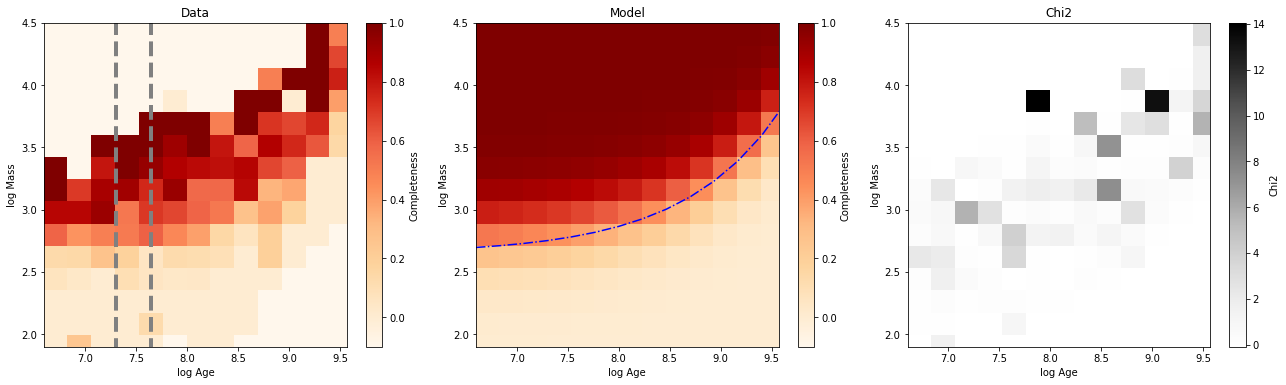

In [290]:
by_hand=get_model(yedges_mass[:-1], Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_)

fc_com=com[:-1]
fc_mod=by_hand
fc_err=err[:-1]

where_data=np.where(fc_com != -.1)
where_are_NaNs = np.where(fc_com == -.1)

sc_com=fc_com[where_data]
sc_mod=fc_mod[where_data]
sc_err=fc_err[where_data]

tot_chi2=np.sum((sc_com-sc_mod)**2/(sc_err**2))
print(tot_chi2)

n=len(sc_com)
fr_p=3

reduced_chi2= tot_chi2/(n-fr_p)
print(reduced_chi2)

by_hand[bin_size-2] = -.1
by_hand[bin_size-2][bin_size-2]=1


chi2=(fc_com-fc_mod)**2/(fc_err**2)
chi2[where_are_NaNs] = -.1

where_big_chi2=np.where(chi2>20)
chi2[where_big_chi2]=1

    
fig=plt.figure()
ax1=plt.subplot(1,3,1)
ax1.set_title('Data')
im1=ax1.pcolormesh(xedges_mass,yedges_mass, com.T,cmap="OrRd")
#ax1.colorbar(label='Completeness')
ax1.set_xlim(6.6, 9.57)
ax1.vlines(x=[7.3, 7.65], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax1.set_xlabel('log Age')
ax1.set_ylabel('log Mass')
ax1.set_ylim(1.9, 4.5)
fig.colorbar(im1, label='Completeness')

ax2=plt.subplot(1,3,2)
ax2.set_title('Model')
im2=ax2.pcolormesh(xedges_mass[:-1],yedges_mass, by_hand.T,cmap="OrRd")
ax2.plot(xedges_mass[:-2], exponential(Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_), linestyle='-.', color='b')
ax2.set_xlabel('log Age')
ax2.set_ylabel('log Mass')
ax2.set_xlim(6.6, 9.57)
ax2.set_ylim(1.9, 4.5)
fig.colorbar(im2, label='Completeness')

ax3=plt.subplot(1,3,3)
ax3.set_title('Chi2')
im3=ax3.pcolormesh(xedges_mass[:-1],yedges_mass, chi2.T,cmap="Greys")
#ax2.plot(xedges_mass[:-1], exponential(Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_), linestyle='-.', color='b')
ax3.set_xlabel('log Age')
ax3.set_ylabel('log Mass')
ax3.set_xlim(6.6, 9.57)
ax3.set_ylim(1.9, 4.5)
fig.colorbar(im3, label='Chi2')

plt.subplots_adjust(right=3, top=1.25, wspace=.14)


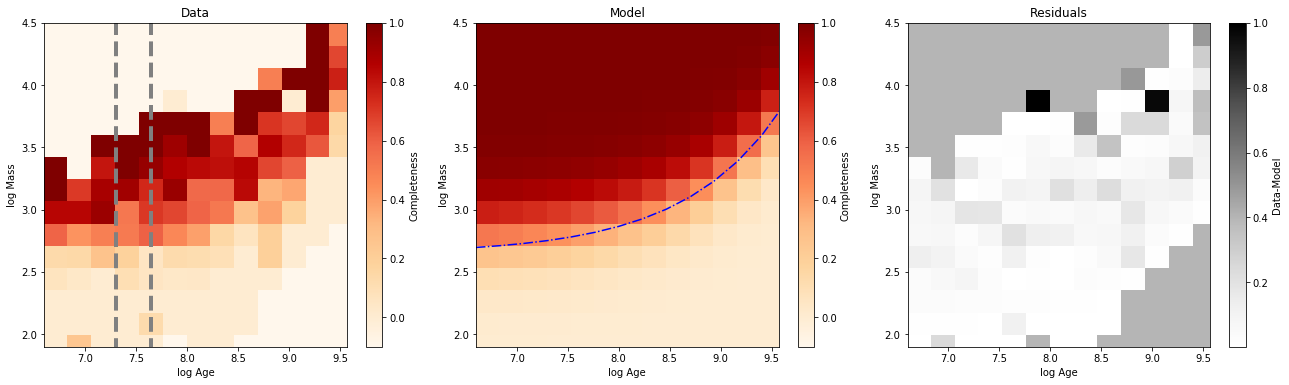

In [291]:
residuals=abs(fc_com-fc_mod)

residuals[bin_size-2][bin_size-2]=1

residuals[where_are_NaNs]=.4
    
fig=plt.figure()
ax1=plt.subplot(1,3,1)
ax1.set_title('Data')
im1=ax1.pcolormesh(xedges_mass,yedges_mass, com.T,cmap="OrRd")
#ax1.colorbar(label='Completeness')
ax1.set_xlim(6.6, 9.57)
ax1.vlines(x=[7.3, 7.65], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax1.set_xlabel('log Age')
ax1.set_ylabel('log Mass')
ax1.set_ylim(1.9, 4.5)
fig.colorbar(im1, label='Completeness')

ax2=plt.subplot(1,3,2)
ax2.set_title('Model')
im2=ax2.pcolormesh(xedges_mass[:-1],yedges_mass, by_hand.T,cmap="OrRd")
ax2.plot(xedges_mass[:-2], exponential(Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_), linestyle='-.', color='b')
ax2.set_xlabel('log Age')
ax2.set_ylabel('log Mass')
ax2.set_xlim(6.6, 9.57)
ax2.set_ylim(1.9, 4.5)
fig.colorbar(im2, label='Completeness')

ax3=plt.subplot(1,3,3)
ax3.set_title('Residuals')
im3=ax3.pcolormesh(xedges_mass[:-1],yedges_mass, residuals.T,cmap="Greys")
#ax2.plot(xedges_mass[:-1], exponential(Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_), linestyle='-.', color='b')
ax3.set_xlabel('log Age')
ax3.set_ylabel('log Mass')
ax3.set_xlim(6.6, 9.57)
ax3.set_ylim(1.9, 4.5)
fig.colorbar(im3, label='Data-Model')

plt.subplots_adjust(right=3, top=1.25, wspace=.14)

In [216]:
#Now F475

(23, 18)

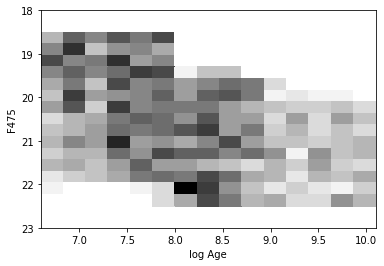

In [296]:
tot_475,xedges_f475,yedges_f475,im=plt.hist2d(gb_si['LOGAGE'], gb_si['F475TOT'], bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
plt.xlabel('log Age')
plt.ylabel('F475')
plt.ylim(23,18)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)


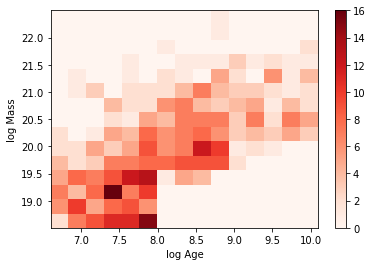

In [297]:
f_475, _, _, _=plt.hist2d(D['LOGAGE'], D['F475TOT'], bins=[xedges_f475, yedges_f475], cmap='Reds', label='Synthetic Clusters')
plt.colorbar()
plt.xlabel('log Age')
plt.ylabel('log Mass')

com_475=f_475/tot_475

where_zeros=np.where(f_475 == 0)
f_475[where_zeros] = 1

err_475=np.zeros((len(f_475), len(f_475)))
for i in range(len(f_475)):
    for j in range(len(f_475)):
        err_475[i][j]=(sm.stats.proportion.proportion_confint(f_475[i][j], tot_475[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f_475[i][j], tot_475[i][j], alpha=.34, method='agresti_coull')[0])/2

where_are_NaNs = np.isnan(com_475)
where_are_inf = np.isinf(com_475)
com_475[where_are_NaNs] = -.1
com_475[where_are_inf] = -.1
err_475[where_are_NaNs]= -.1
err_475[where_are_inf]= -.1

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

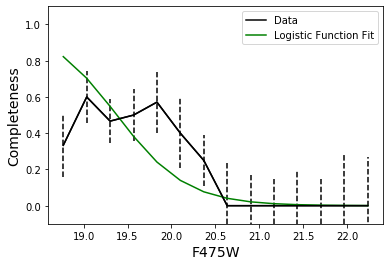

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

[22.23264771]
19.036834926155937


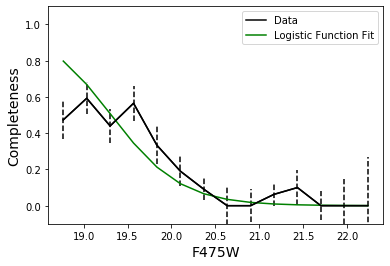

[22.23264771]
18.86015755619296


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

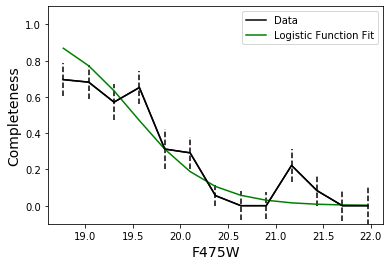

[21.96621475]
19.435682180284328


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

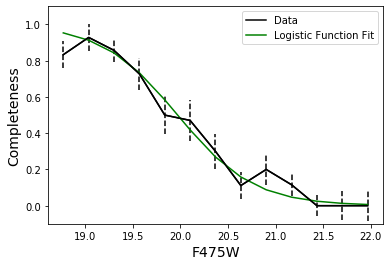

[21.96621475]
20.025186924061835


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

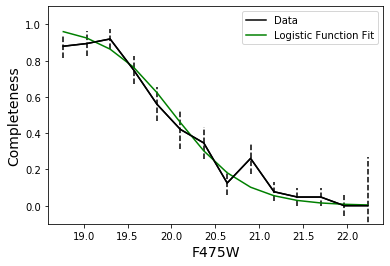

[22.23264771]
20.111758228523456


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

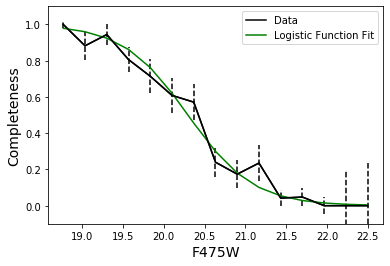

[22.49908066]
20.369706057715934


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

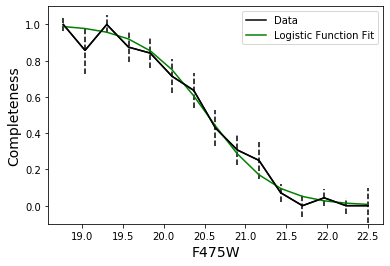

[22.49908066]
20.53581760382511


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

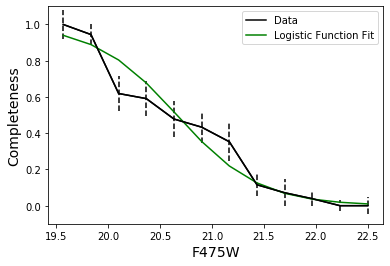

[22.49908066]
20.71869491731934


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

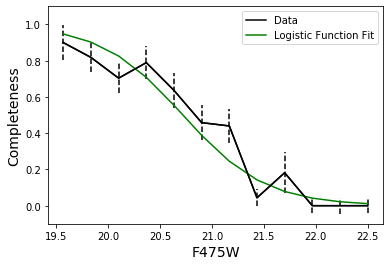

[22.49908066]
20.791999618721935


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

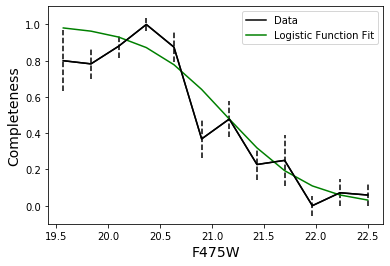

[22.49908066]
20.983428508676628


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

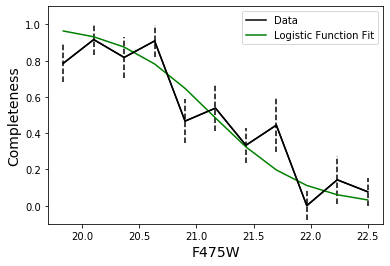

[22.49908066]
21.14916654767725


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

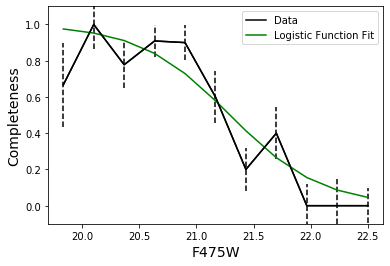

[22.49908066]
21.156042044474


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

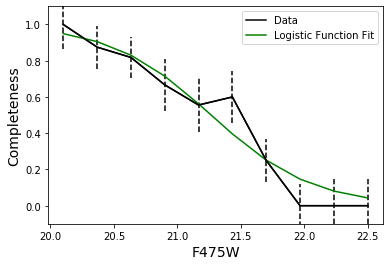

[22.49908066]
21.24963072589725


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

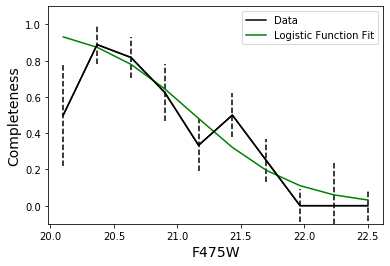

[22.49908066]
20.99781169516405


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

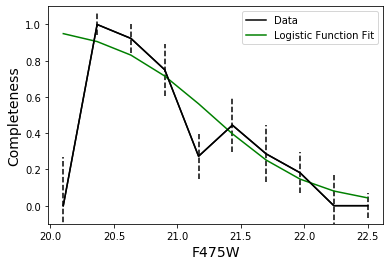

[22.49908066]
20.879140016244055


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional i

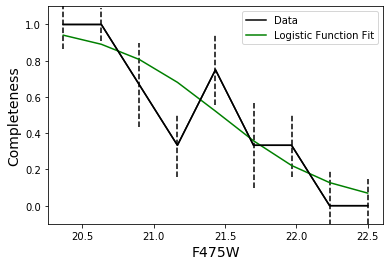

[22.49908066]
21.414042111332996


LogAge_Bin_Min,LogAge_Bin_Med,LogAge_Bin_Max,LF_Fit_X0,LF_Fit_k,50%_Comp,50%_Comp_M2,LF_Values [15]
float64,float64,float64,float64,float64,float64,float64,float64
6.599883079528809,6.833248901367187,7.066614723205566,19.314725195471684,-1.5075268970821658,22.232647705078126,18.86015755619296,0.7979429666954342 .. 0.00033045674823872187
6.833248901367187,7.066614723205566,7.299980545043946,19.52058688457634,-2.027426443511905,21.966214752197267,19.435682180284328,0.8689401782117081 .. 0.0005546763272732735
7.066614723205566,7.299980545043946,7.533346366882324,19.970158733648837,-2.234651969060399,21.966214752197267,20.025186924061835,0.9536089795130034 .. 0.0017177108442590757
7.299980545043946,7.533346366882324,7.766712188720703,20.035805145816745,-2.301506146643205,22.232647705078126,20.111758228523456,0.9603943901084168 .. 0.002025688008184438
7.533346366882324,7.766712188720703,8.000078010559083,20.29733202264594,-2.4767574150882394,22.499080657958984,20.369706057715934,0.9790943846510597 .. 0.003905014435091291
7.766712188720703,8.000078010559083,8.23344383239746,20.538456229039742,-2.5571280683168873,22.499080657958984,20.53581760382511,0.9884960678572852 .. 0.007141285111043779
8.000078010559083,8.23344383239746,8.46680965423584,20.662090036440723,-2.428121710786497,22.499080657958984,20.71869491731934,0.9915463692683582 .. 0.00972269953728406
8.23344383239746,8.46680965423584,8.700175476074218,20.720156490349115,-2.628232570611955,22.499080657958984,20.791999618721935,0.9926874016466876 .. 0.011235539305400477
8.46680965423584,8.700175476074218,8.933541297912598,21.131929973421542,-3.7159421661218683,22.499080657958984,20.983428508676628,0.9973936891962523 .. 0.031038949689286298


In [298]:
fl_fits=np.zeros((len(xedges_f475),4))

bin_try=np.zeros((len(xedges_f475), 3))

bin_try[0]=(xedges_f475[0], (xedges_f475[0]+xedges_f475[1])/2, xedges_f475[1])
bin_try[bin_size]=(xedges_f475[bin_size-1], (xedges_f475[bin_size-1]+xedges_f475[bin_size])/2,
                   xedges_f475[bin_size])

for i in range(1,len(xedges_f475)-1):
    bin_try[i]=[xedges_f475[i-1], xedges_f475[i], xedges_f475[i+1]]

def get_com_mod_f745(bin1, gb_si, D): 
    syn_ind=np.where((gb_si['LOGAGE'] >= bin1[0]) & (gb_si['LOGAGE'] < bin1[2]))
    found_ind=np.where((D['LOGAGE'] >= bin1[0]) & (D['LOGAGE'] < bin1[2]))
    clsts=gb_si[syn_ind]
    found=D[found_ind]

    plt.ioff()
    fig1=plt.figure()
    ys,bins,_=plt.hist(clsts['F475TOT'], histtype='step', color='r', bins=yedges_f475, label='Total')
    h,x,_=plt.hist(found['F475TOT'], histtype='step', color='k', bins=yedges_f475, label='Detected')
    plt.xlabel('F475')
    plt.ylabel('N Synthetic Clusters')
    plt.legend()
    plt.close(fig1)
    
    tot=ys
    f475_com=h/tot
    #Setting error for places with no found to be 1 in error
    where_zeros=np.where(h == 0)
    h[where_zeros] = 1

    err=np.zeros((len(h)))
    for i in range(len(h)):
        err[i]=(sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[0])/2

    where_are_NaNs = np.isnan(f475_com)
    where_data = [~np.isnan(f475_com)]

    #Only try and fit bins where I have data
    use_com=f475_com[where_data]
    use_edges=yedges_f475[1:][where_data]
    use_err=err[where_data]

    initial_guess=[np.median(use_edges), -2]
    initial_guess_f=[np.median(use_edges)]

    (x0_, k_),_ = opt.curve_fit(gen_logistic_func, xdata=use_edges, ydata=use_com, sigma=use_err, p0=initial_guess, maxfev=500000)
    
    lf_fit=gen_logistic_func(use_edges, x0=x0_, k=k_)
    
    (fx0_),_ = opt.curve_fit(forced_slope_gen_logistic_func_f475, xdata=use_edges, ydata=use_com, sigma=use_err, p0=initial_guess_f, maxfev=500000)
    
    
    lf_fit_forced_ss=forced_slope_gen_logistic_func_f475(use_edges, x0=fx0_)
    
    
    plt.plot(use_edges, use_com, color='k', label='Data')
    eb=plt.errorbar(use_edges, use_com, yerr=use_err, color='k')
    eb[-1][0].set_linestyle('--')
#    plt.plot(use_edges, lf_fit, color='b', label='Fit')
    plt.plot(use_edges, lf_fit_forced_ss, color='g', label='Logistic Function Fit')
    plt.xlabel('F475W', fontsize=14)
    plt.ylabel('Completeness', fontsize=14)
#    plt.text(19.5, .995, str('Log age:')+str("{:.2f}".format(bin1[0]))+str(':')+str("{:.2f}".format(bin1[2])) ,bbox={'facecolor':'w'})
    plt.legend()
    plt.ylim(-.1,1.1)
    plt.show()
#    plt.close()
    
        
    ptile=[.50]
    ptile_out = np.interp(ptile, fp=use_edges, xp=lf_fit)
    print(ptile_out)
    
    hi=completeness(linear_poly1, use_edges, use_com)
    print(hi)

    par= [fx0_, k_, ptile_out, hi]
    
    return par


for i in range(len(yedges_f475)):                                  
    fl_fits[i]= get_com_mod_f745(bin_try[i], gb_si, D)
    
fl_fits

bined_fit_array_f475=np.zeros((len(yedges_f475)-1, bin_size))

for i in range((len(yedges_f475)-1)):
    bined_fit_array_f475[i]= forced_slope_gen_logistic_func_f475(yedges_f475[1:], x0=fl_fits[i][0])
    
bined_fit_array_f475[bin_size-1][bin_size-1]=-.1
bined_fit_array_f475[bin_size-1][bin_size-2]=1.0

#Making Data accessible
lefts=[]
mids=[]
rights=[]
x0s=[]
ks=[]
Ls=[]
fiftys=[]
fiftys_m2=[]

for i in range(len(bin_try)):
    lefts.append(bin_try[i][0])
    mids.append(bin_try[i][1])
    rights.append(bin_try[i][2])
    x0s.append(fl_fits[i][0])
    ks.append(fl_fits[i][1])
    fiftys.append(fl_fits[i][2])
    fiftys_m2.append(fl_fits[i][3])

F475_logistic_table=Table((lefts[:-1], mids[:-1], rights[:-1], x0s[:-1], ks[:-1], fiftys[:-1], fiftys_m2[:-1], bined_fit_array_f475),
                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0', 'LF_Fit_k', '50%_Comp', '50%_Comp_M2',
                             'LF_Values'))
F475_logistic_table=F475_logistic_table[1:]
F475_logistic_table

In [293]:
np.median(F475_logistic_table['LF_Fit_k'])

-2.5169427417025636

In [355]:
ex_initial_guess= [-2.6, -.7, 21.2]
mags=yedges_f475[:-1]
ages= np.array(F475_logistic_table['LogAge_Bin_Med'])

nll = lambda *args: -lnlike_F475(*args)

result = op.minimize(nll, x0=ex_initial_guess, args=(mags, ages, com_475, err_475))

ae_, be_, ce_ =result['x']
ae_,  be_, ce_

(-2.6346950036500307, -0.7148267889295219, 21.296108884818253)

201.9927134081614
1.2095372060368945


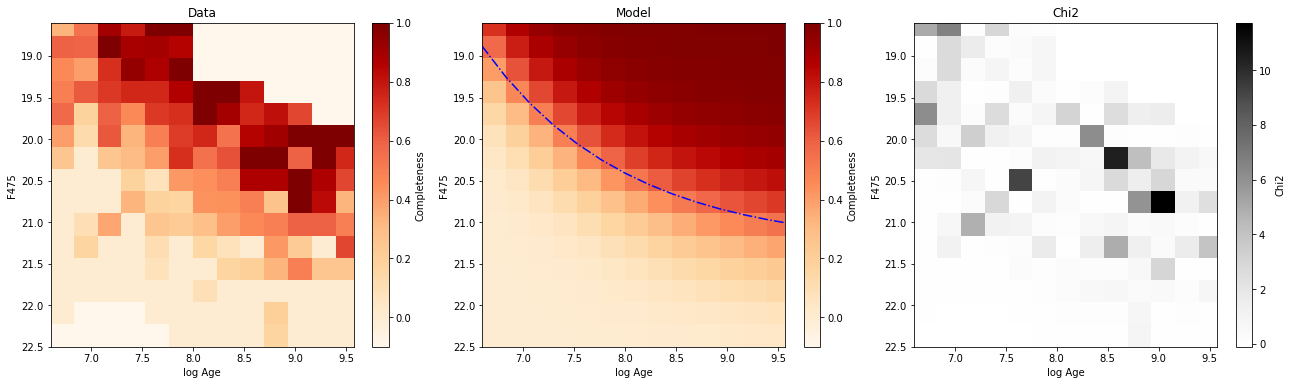

In [356]:
by_hand_475=get_model_F475(yedges_f475[:-1], F475_logistic_table['LogAge_Bin_Med'], ae_,be_,ce_)

fc_com=com_475[:-1]
fc_mod=by_hand_475
fc_err=err_475[:-1]

where_data=np.where(fc_com != -.1)
where_are_NaNs= np.where(fc_com == -.1)

sc_com=fc_com[where_data]
sc_mod=fc_mod[where_data]
sc_err=fc_err[where_data]

tot_chi2_475=np.sum((sc_com-sc_mod)**2/(sc_err**2))
print(tot_chi2_475)

n=len(sc_com)
fr_p=3

reduced_chi2_475= tot_chi2_475/(n-fr_p)
print(reduced_chi2_475)

by_hand_475[bin_size-2] = -.1
by_hand_475[bin_size-2][bin_size-1]=1


chi2_475=(fc_com-by_hand_475)**2/(fc_err**2)
chi2_475[where_are_NaNs] = -.1

where_big_chi2_475=np.where(chi2_475>20)
chi2_475[where_big_chi2_475]=1

    
fig=plt.figure()
ax1=plt.subplot(1,3,1)
ax1.set_title('Data')
im1=ax1.pcolormesh(xedges_f475[:-1],yedges_f475, com_475.T,cmap="OrRd")
#ax1.colorbar(label='Completeness')
ax1.set_xlim(6.6, 9.57)
#ax1.vlines(x=[7.3, 7.65], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax1.set_xlabel('log Age')
ax1.set_ylabel('F475')
ax1.set_ylim(22.5,18.6)
fig.colorbar(im1, label='Completeness')

ax2=plt.subplot(1,3,2)
ax2.set_title('Model')
im2=ax2.pcolormesh(xedges_f475[:-1],yedges_f475, by_hand_475.T,cmap="OrRd")
ax2.plot(xedges_f475[:-2], exponential(F475_logistic_table['LogAge_Bin_Med'], ae_,be_,ce_), linestyle='-.', color='b')
ax2.set_xlabel('log Age')
ax2.set_ylabel('F475')
ax2.set_xlim(6.6, 9.57)
ax2.set_ylim(22.5,18.6)
fig.colorbar(im2, label='Completeness')

ax3=plt.subplot(1,3,3)
ax3.set_title('Chi2')
im3=ax3.pcolormesh(xedges_f475[:-1],yedges_f475, chi2_475.T,cmap="Greys")
#ax2.plot(xedges_mass[:-1], exponential(Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_), linestyle='-.', color='b')
ax3.set_xlabel('log Age')
ax3.set_ylabel('F475')
ax3.set_xlim(6.6, 9.57)
ax3.set_ylim(22.5,18.6)
fig.colorbar(im3, label='Chi2')

plt.subplots_adjust(right=3, top=1.25, wspace=.14)

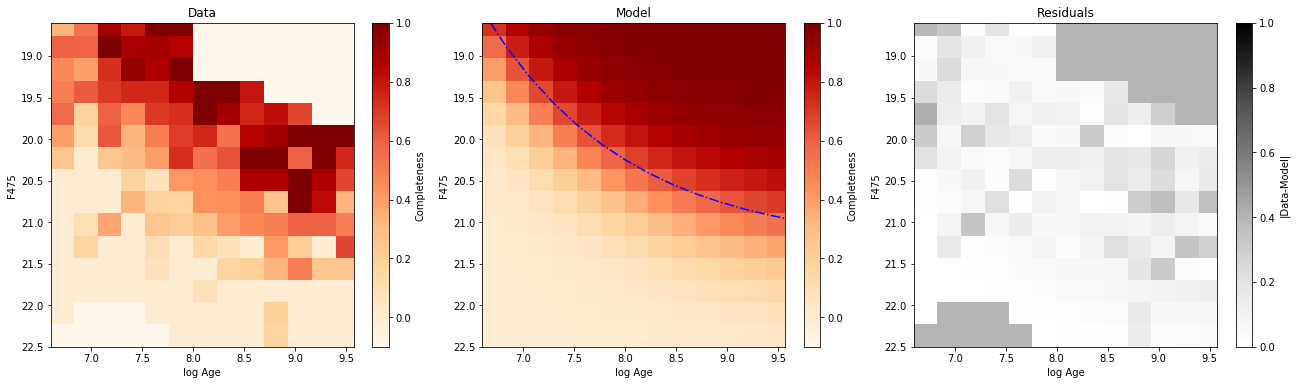

In [357]:
residuals_475=abs(fc_com-by_hand_475)

residuals_475[where_are_NaNs]=.4

where_big_res_475=np.where(residuals_475 > 1)
residuals_475[where_big_res_475]=0

fig=plt.figure()
ax1=plt.subplot(1,3,1)
ax1.set_title('Data')
im1=ax1.pcolormesh(xedges_f475[:-1],yedges_f475,com_475.T,cmap="OrRd")
#ax1.colorbar(label='Completeness')
ax1.set_xlim(6.6, 9.57)
#ax1.vlines(x=[7.3, 7.65], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax1.set_xlabel('log Age')
ax1.set_ylabel('F475')
ax1.set_ylim(22.5,18.6)
fig.colorbar(im1, label='Completeness')

ax2=plt.subplot(1,3,2)
ax2.set_title('Model')
im2=ax2.pcolormesh(xedges_f475[:-1],yedges_f475, by_hand_475.T,cmap="OrRd")
ax2.plot(xedges_f475[:-2], exponential(F475_logistic_table['LogAge_Bin_Min'], ae_,be_,ce_), linestyle='-.', color='b')
ax2.set_xlabel('log Age')
ax2.set_ylabel('F475')
ax2.set_xlim(6.6, 9.57)
ax2.set_ylim(22.5,18.6)
fig.colorbar(im2, label='Completeness')

ax3=plt.subplot(1,3,3)
ax3.set_title('Residuals')
im3=ax3.pcolormesh(xedges_f475[:-1],yedges_f475, residuals_475.T,cmap="Greys")
ax3.set_xlabel('log Age')
ax3.set_ylabel('F475')
ax3.set_xlim(6.6, 9.57)
ax3.set_ylim(22.5,18.6)
fig.colorbar(im3, label='|Data-Model|')

plt.subplots_adjust(right=3, top=1.25, wspace=.14)

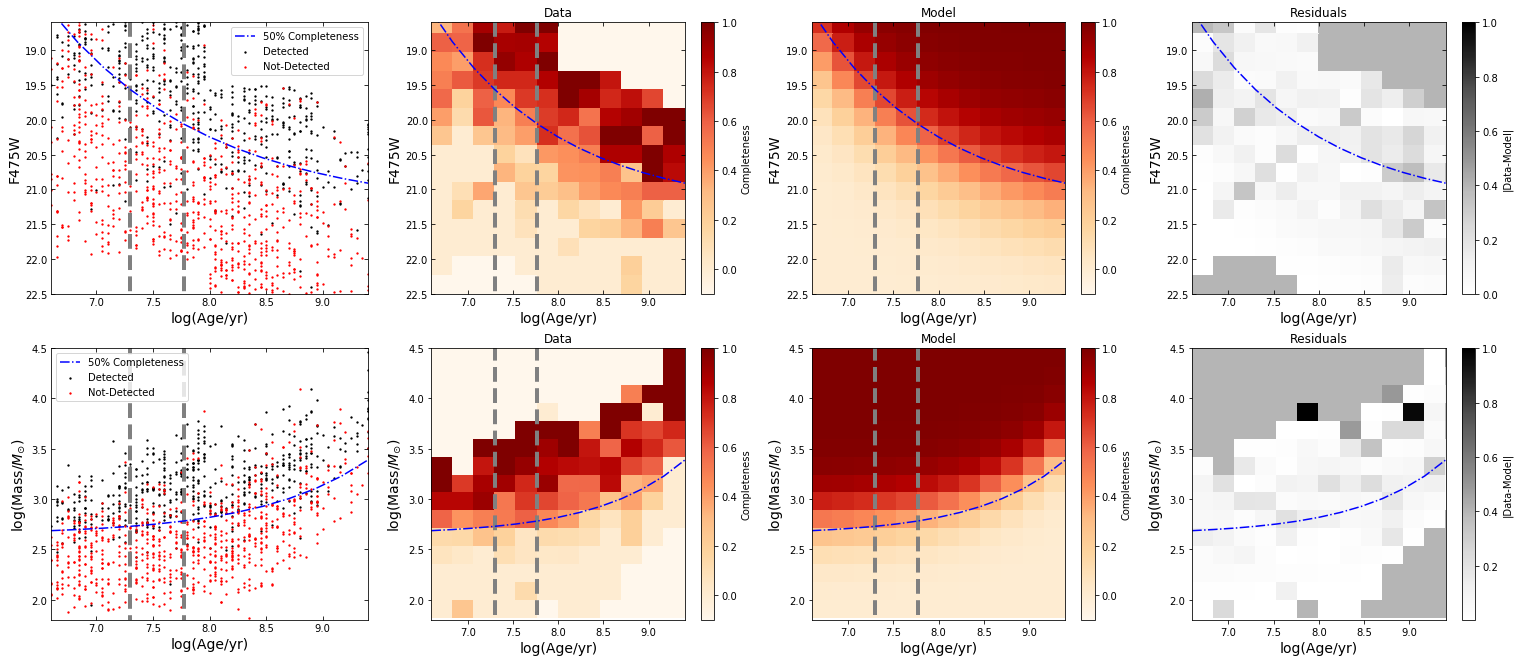

In [361]:
fig=plt.figure()
ax1=plt.subplot(2,4,1)
ax1.scatter(D['LOGAGE'], D['F475TOT'],color='k', s=1.7, label='Detected')
ax1.scatter(ND['LOGAGE'], ND['F475TOT'], color='r', s=1.7, label='Not-Detected')
ax1.plot(F475_logistic_table['LogAge_Bin_Min'], exponential(F475_logistic_table['LogAge_Bin_Min'], ae_,be_,ce_), linestyle='-.', color='b', label='50% Completeness')
ax1.vlines(x=[7.3, 7.77], ymin=18.6, ymax=23, color='gray', linestyle='--', linewidth=4)
ax1.set_ylim(22.5,18.6)
ax1.set_xlim(6.51,9.4)
ax1.set_xlabel('log(Age/yr)', fontsize=14)
ax1.set_ylabel('F475W', fontsize=14)
ax1.tick_params(axis='y', left=True, right=True, direction='in', which='both', length=4)
ax1.tick_params(axis='x', top=True, direction='in', which='both', length=4)
ax1.legend()

ax2=plt.subplot(2,4,2, sharex=ax1)
ax2.set_title('Data')
im2=ax2.pcolormesh(xedges_f475[:-1],yedges_f475,com_475.T,cmap="OrRd")
fig.colorbar(im2, label='Completeness', ax=ax2)
ax2.vlines(x=[7.3, 7.77], ymin=18.6, ymax=23, color='gray', linestyle='--', linewidth=4)
ax2.plot(F475_logistic_table['LogAge_Bin_Min'], exponential(F475_logistic_table['LogAge_Bin_Min'], ae_,be_,ce_), linestyle='-.', color='b')
ax2.set_ylim(22.5,18.6)
ax2.set_xlim(6.6, 9.4)
ax2.set_xlabel('log(Age/yr)', fontsize=14)
ax2.set_ylabel('F475W', fontsize=14)
ax2.tick_params(axis='y', left=True, right=True, direction='in', which='both', length=4)
ax2.tick_params(axis='x', top=True, direction='in', which='both', length=4)

ax3=plt.subplot(2,4,3, sharex=ax1)
ax3.set_title('Model')
im3=ax3.pcolormesh(xedges_f475[:-1],yedges_f475,by_hand_475.T,cmap="OrRd")
ax3.plot(F475_logistic_table['LogAge_Bin_Min'], exponential(F475_logistic_table['LogAge_Bin_Min'], ae_,be_,ce_), linestyle='-.', color='b')
ax3.vlines(x=[7.3, 7.77], ymin=18.6, ymax=23, color='gray', linestyle='--', linewidth=4)
ax3.set_xlabel('log(Age/yr)', fontsize=14)
ax3.set_ylabel('F475W', fontsize=14)
ax3.set_xlim(6.6, 9.4)
ax3.set_ylim(22.5,18.6)
ax3.tick_params(axis='y', left=True, right=True, direction='in', which='both', length=4)
ax3.tick_params(axis='x', top=True, direction='in', which='both', length=4)
fig.colorbar(im3, label='Completeness', ax=ax3)

ax4=plt.subplot(2,4,4)
ax4.set_title('Residuals')
im4=ax4.pcolormesh(xedges_f475[:-1],yedges_f475, residuals_475.T,cmap="Greys")
ax4.plot(F475_logistic_table['LogAge_Bin_Min'], exponential(F475_logistic_table['LogAge_Bin_Min'], ae_,be_,ce_), linestyle='-.', color='b')
ax4.set_xlabel('log(Age/yr)', fontsize=14)
ax4.set_ylabel('F475W', fontsize=14)
ax4.set_ylim(22.5,18.6)
ax4.set_xlim(6.6, 9.4)
ax4.tick_params(axis='y', left=True, right=True, direction='in', which='both', length=4)
ax4.tick_params(axis='x', top=True, direction='in', which='both', length=4)
fig.colorbar(im4, label='|Data-Model|', ax=ax4)

ax5=plt.subplot(2,4,5, sharex=ax1)
ax5.scatter(D['LOGAGE'], np.log10(D['MASSOUT']),color='k', s=1.7, label='Detected')
ax5.scatter(ND['LOGAGE'], np.log10(ND['MASSOUT']), color='r', s=1.7, label='Not-Detected')
ax5.plot(Mass_logistic_table['LogAge_Bin_Min'], exponential(Mass_logistic_table['LogAge_Bin_Min'], a_,b_,c_), linestyle='-.', color='b', label='50% Completeness')
ax5.vlines(x=[7.3, 7.77], ymin=1.7, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax5.set_ylim(1.8,4.5)
ax5.set_xlim(6.51,9.4)
ax5.set_xlabel('log(Age/yr)', fontsize=14)
ax5.set_ylabel('log(Mass/$M_{\odot}$)', fontsize=14)
ax5.tick_params(axis='y', left=True, right=True, direction='in', which='both', length=4)
ax5.tick_params(axis='x', top=True, direction='in', which='both', length=4)
ax5.legend()

ax6=plt.subplot(2,4,6, sharex=ax1)
ax6.set_title('Data')
im6=ax6.pcolormesh(xedges_mass[:-1],yedges_mass,com.T,cmap="OrRd")
ax6.plot(Mass_logistic_table['LogAge_Bin_Min'], exponential(Mass_logistic_table['LogAge_Bin_Min'], a_,b_,c_), linestyle='-.', color='b')
ax6.vlines(x=[7.3, 7.77], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax6.set_xlim(6.6, 9.4)
ax6.set_ylim(1.8,4.5)
ax6.set_xlabel('log(Age/yr)', fontsize=14)
ax6.set_ylabel('log(Mass/$M_{\odot}$)', fontsize=14)
fig.colorbar(im6, label='Completeness', ax=ax6)

ax7=plt.subplot(2,4,7, sharex=ax1)
ax7.set_title('Model')
im7=ax7.pcolormesh(xedges_mass[:-1],yedges_mass,by_hand.T,cmap="OrRd")
ax7.plot(Mass_logistic_table['LogAge_Bin_Min'], exponential(Mass_logistic_table['LogAge_Bin_Min'], a_,b_,c_), linestyle='-.', color='b')
ax7.vlines(x=[7.3, 7.77], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax7.set_xlabel('log(Age/yr)', fontsize=14)
ax7.set_ylabel('log(Mass/$M_{\odot}$)', fontsize=14)
ax7.set_xlim(6.6, 9.4)
ax7.set_ylim(1.8,4.5)
fig.colorbar(im7, label='Completeness', ax=ax7)

ax8=plt.subplot(2,4,8)
ax8.set_title('Residuals')
im8=ax8.pcolormesh(xedges_mass[:-1],yedges_mass, residuals.T,cmap="Greys")
ax8.plot(Mass_logistic_table['LogAge_Bin_Min'], exponential(Mass_logistic_table['LogAge_Bin_Min'], a_,b_,c_), linestyle='-.', color='b')
ax8.set_xlabel('log(Age/yr)', fontsize=14)
ax8.set_ylabel('log(Mass/$M_{\odot}$)', fontsize=14)
ax8.set_xlim(6.6, 9.4)
ax8.set_ylim(1.8, 4.5)
fig.colorbar(im8, label='|Data-Model|', ax=ax8)

plt.subplots_adjust(right=3.5, top=2.2, hspace=.2, wspace=.2)
plt.savefig('/Volumes/RESEARCH/Research/Cluster_Catalog/Final_plots/Completeness.pdf', format='pdf', bbox_inches='tight')

In [ ]:
#NMS Analysis

In [ ]:
#Splitting up the Syntetics by NMS

high_nms_ind=np.where((gb_si['NMS'] > 1000) &  (gb_si['LOGAGE'] <= 9.3))
low_nms_ind=np.where((gb_si['NMS'] <= 1000) &  (gb_si['LOGAGE'] <= 9.3))

high_nms=gb_si[high_nms_ind]
low_nms=gb_si[low_nms_ind]

low_nms

high_nms_D_ind=np.where(high_nms['WEIGHTED_DETECTED_.674'] >= .674)
low_nms_D_ind=np.where(low_nms['WEIGHTED_DETECTED_.674'] >= .674)

high_nms_D=high_nms[high_nms_D_ind]
low_nms_D=low_nms[low_nms_D_ind]

In [ ]:
bin_size=11

x,xedges_h,yedges_h,im=plt.hist2d(high_nms['LOGAGE'], np.log10(high_nms['MASSOUT']), bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
plt.xlabel('log Age')
plt.ylabel('log Mass')

In [ ]:
f,_,_,_=plt.hist2d(high_nms_D['LOGAGE'], np.log10(high_nms_D['MASSOUT']), bins=[xedges_h, yedges_h], cmap='Reds', label='Synthetic Clusters')
plt.colorbar()
plt.xlabel('log Age')
plt.ylabel('log Mass')

h_com=np.array(f/x)

err_h=np.zeros((len(f), len(f)))
for i in range(len(f)):
    for j in range(len(f)):
        err_h[i][j]=(sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[0])/2


where_are_NaNs = np.isnan(h_com)
where_are_inf = np.isinf(h_com)
h_com[where_are_NaNs] = -.1
h_com[where_are_inf] = -.1
err_h[where_are_NaNs]= -.1
err_h[where_are_inf]= -.1

In [ ]:
x,xedges_l,yedges_l,im=plt.hist2d(low_nms['LOGAGE'], np.log10(low_nms['MASSOUT']), bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
plt.xlabel('log Age')
plt.ylabel('log Mass')

In [ ]:
f, _,_,_=plt.hist2d(low_nms_D['LOGAGE'], np.log10(low_nms_D['MASSOUT']), bins=[xedges_l, yedges_l], cmap='Reds', label='Synthetic Clusters')
plt.colorbar()
plt.xlabel('log Age')
plt.ylabel('log Mass')

l_com=np.array(f/x)

err_l=np.zeros((len(f), len(f)))
for i in range(len(f)):
    for j in range(len(f)):
        err_l[i][j]=(sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[0])/2


where_are_NaNs = np.isnan(l_com)
where_are_inf = np.isinf(l_com)
l_com[where_are_NaNs] = -.1
l_com[where_are_inf] = -.1
err_l[where_are_NaNs]= -.1
err_l[where_are_inf]= -.1

In [ ]:
high_nms_fl_fits=np.zeros((len(xedges_h),4))
low_nms_fl_fits=np.zeros((len(xedges_l),4))

bin_try_h=np.zeros((len(xedges_h), 3))
bin_try_h[0]=(xedges_h[0], (xedges_h[0]+xedges_h[1])/2, xedges_h[1])
bin_try_h[bin_size]=(xedges_h[bin_size-1], (xedges_h[bin_size-1]+xedges_h[bin_size])/2,
                   xedges_h[bin_size])

for i in range(1,len(xedges_h)-1):
    bin_try_h[i]=[xedges_h[i-1], xedges_h[i], xedges_h[i+1]]
    
bin_try_l=np.zeros((len(xedges_l), 3))
bin_try_l[0]=(xedges_l[0], (xedges_l[0]+xedges_l[1])/2, xedges_l[1])
bin_try_l[bin_size]=(xedges_l[bin_size-1], (xedges_l[bin_size-1]+xedges_l[bin_size])/2,
                   xedges_l[bin_size])

for i in range(1,len(xedges_l)-1):
    bin_try_l[i]=[xedges_l[i-1], xedges_l[i], xedges_l[i+1]]
    
    
for i in range(len(yedges_h)):                                  
    high_nms_fl_fits[i]= get_com_mod(bin_try_h[i], high_nms, high_nms_D, yedges_h)
    low_nms_fl_fits[i]= get_com_mod(bin_try_l[i], low_nms, low_nms_D, yedges_l)

high_nms_bined_fit_array=np.zeros((len(yedges_h)-1, bin_size))
low_nms_bined_fit_array=np.zeros((len(yedges_h)-1, bin_size))

for i in range((len(yedges_h)-1)):
    high_nms_bined_fit_array[i]= forced_slope_gen_logistic_func(yedges_h[:-1], x0=high_nms_fl_fits[i][0])
    low_nms_bined_fit_array[i]=forced_slope_gen_logistic_func(yedges_l[:-1], x0=low_nms_fl_fits[i][0])

#Making Data accessible
h_lefts=[]
h_mids=[]
h_rights=[]
l_lefts=[]
l_mids=[]
l_rights=[]
h_x0s=[]
h_fiftys=[]
h_ks=[]
l_x0s=[]
l_fiftys=[]
l_ks=[]
    
for i in range(len(bin_try_h)):
    h_lefts.append(bin_try_h[i][0])
    h_mids.append(bin_try_h[i][1])
    h_rights.append(bin_try_h[i][2])
    l_lefts.append(bin_try_l[i][0])
    l_mids.append(bin_try_l[i][1])
    l_rights.append(bin_try_l[i][2])
    
    h_x0s.append(high_nms_fl_fits[i][0])
    h_fiftys.append(high_nms_fl_fits[i][2])
    h_ks.append(high_nms_fl_fits[i][1])
    l_x0s.append(low_nms_fl_fits[i][0])
    l_fiftys.append(low_nms_fl_fits[i][2])
    l_ks.append(low_nms_fl_fits[i][1])

high_nms_logistic_table=Table((h_lefts[:-1], h_mids[:-1], h_rights[:-1], h_x0s[:-1], h_ks[:-1], h_fiftys[:-1], high_nms_bined_fit_array),
                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0', 'LF_Fit_k', '50%_Comp',
                             'LF_Values'))
low_nms_logistic_table=Table((l_lefts[:-1], l_mids[:-1], l_rights[:-1], l_x0s[:-1], l_ks[:-1], l_fiftys[:-1], low_nms_bined_fit_array),
                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0','LF_Fit_k', '50%_Comp',
                             'LF_Values'))

In [ ]:
high_nms_logistic_table
print(np.median(high_nms_logistic_table['LF_Fit_k'][:-2]))
print(np.median(low_nms_logistic_table['LF_Fit_k'][:-2]))


    
#Need to adjust the fixed slope of the logistic funtion for the new 

def new_log_func_high(x, age, a, b, c):
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    k=7.205
    
    x0 = exponential(age, a, b, c)
    
    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))


def new_log_func_low(x, age, a, b, c):
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    k=7.847
    
    x0 = exponential(age, a, b, c)
    
    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))
    
def get_model_high(masses, ages, a, b, c):

    maybe=np.zeros((len(masses), len(masses) ))

    for i in range((len(masses))):
        maybe[i]= new_log_func_high(masses, ages[i], a, b, c)
    
    return maybe

def get_model_low(masses, ages, a, b, c):

    maybe=np.zeros((len(masses), len(masses) ))

    for i in range((len(masses))):
        maybe[i]= new_log_func_low(masses, ages[i], a, b, c)
    
    return maybe

def lnlike_high(theta, masses, ages, com, err):
    a, b, c = theta
    
    model=get_model_high(masses, ages, a, b, c)

    
    fc_com=com[:-1]
    fc_model=model[:-1].astype('float32')
    fc_err=err[:-1]
    
    where_data = np.where(fc_com != -.1)
    
    use_com=fc_com[where_data]
    use_model=fc_model[where_data]
    use_err=fc_err[where_data]
    
    chi2= ((use_com-use_model)**2) / (use_err**2)

    return np.sum( -chi2 - 2)

def lnlike_low(theta, masses, ages, com, err):
    a, b, c = theta
    
    model=get_model_low(masses, ages, a, b, c)

    
    fc_com=com[:-1]
    fc_model=model[:-1].astype('float32')
    fc_err=err[:-1]
    
    where_data = np.where(fc_com != -.1)
    
    use_com=fc_com[where_data]
    use_model=fc_model[where_data]
    use_err=fc_err[where_data]
    
    chi2= ((use_com-use_model)**2) / (use_err**2)

    return np.sum( -chi2 - 2)

In [ ]:
ex_initial_guess= [.06, 1.06, 2.99]
masses_h=yedges_h[:-1]
ages= np.array(high_nms_logistic_table['LogAge_Bin_Med'])

nll = lambda *args: -lnlike_high(*args)

h_result = op.minimize(nll, x0=ex_initial_guess, args=(masses_h, ages, h_com, err_h))

ha_, hb_, hc_ =h_result['x']
ha_,  hb_, hc_

In [ ]:
nll = lambda *args: -lnlike_low(*args)
masses_l=yedges_l[:-1]
l_result = op.minimize(nll, x0=ex_initial_guess, args=(masses_l, ages, l_com, err_l))

la_, lb_, lc_ =l_result['x']
la_,  lb_, lc_

In [ ]:
by_hand_h=get_model_high(yedges_h[:-1], high_nms_logistic_table['LogAge_Bin_Med'], ha_,hb_,hc_)

fc_com=h_com[:-1]
fc_mod=by_hand_h[:-1]
fc_err=err_h[:-1]

where_data=np.where(fc_com != -.1)

sc_com=fc_com[where_data]
sc_mod=fc_mod[where_data]
sc_err=fc_err[where_data]

tot_chi2=np.sum((sc_com-sc_mod)**2/(sc_err**2))
print(tot_chi2)

n=len(sc_com)
fr_p=3

reduced_chi2= tot_chi2/(n-fr_p)
print(reduced_chi2)

by_hand_h[bin_size-1] = -.1
by_hand_h[bin_size-1][bin_size-1]=1


chi2_h=(h_com-by_hand_h)**2/(err_h**2)
chi2_h[where_are_NaNs] = -.1

where_big_chi2=np.where(chi2_h>20)
chi2_h[where_big_chi2]=1

    
fig=plt.figure()
ax1=plt.subplot(1,3,1)
ax1.set_title('Data')
im1=ax1.pcolormesh(xedges_h,yedges_h,h_com.T,cmap="OrRd")
#ax1.colorbar(label='Completeness')
ax1.set_xlim(6.6, 9.)
ax1.vlines(x=[7.3, 7.65], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax1.set_xlabel('log Age')
ax1.set_ylabel('log Mass')
ax1.set_ylim(1.9, 4.1)
fig.colorbar(im1, label='Completeness')

ax2=plt.subplot(1,3,2)
ax2.set_title('Model')
im2=ax2.pcolormesh(xedges_h,yedges_h, by_hand_h.T,cmap="OrRd")
ax2.plot(xedges_h[:-1], exponential(high_nms_logistic_table['LogAge_Bin_Min'], ha_,hb_,hc_), linestyle='-.', color='b')
ax2.set_xlabel('log Age')
ax2.set_ylabel('log Mass')
ax2.set_xlim(6.6, 9.)
ax2.set_ylim(1.9, 4.1)
fig.colorbar(im2, label='Completeness')

ax3=plt.subplot(1,3,3)
ax3.set_title('Chi2')
im3=ax3.pcolormesh(xedges_h,yedges_h, chi2_h.T,cmap="Greys")
#ax2.plot(xedges_mass[:-1], exponential(Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_), linestyle='-.', color='b')
ax3.set_xlabel('log Age')
ax3.set_ylabel('log Mass')
ax3.set_xlim(6.6, 9.)
ax3.set_ylim(1.9, 4.1)
fig.colorbar(im3, label='Chi2')

plt.subplots_adjust(right=3, top=1.25, wspace=.14)


In [ ]:
by_hand_l=get_model_low(yedges_l[:-1], low_nms_logistic_table['LogAge_Bin_Med'], la_,lb_,lc_)

fc_com=l_com[:-1]
fc_mod=by_hand_l[:-1]
fc_err=err_l[:-1]

where_data=np.where(fc_com != -.1)

sc_com=fc_com[where_data]
sc_mod=fc_mod[where_data]
sc_err=fc_err[where_data]

tot_chi2=np.sum((sc_com-sc_mod)**2/(sc_err**2))
print(tot_chi2)

n=len(sc_com)
fr_p=3

reduced_chi2= tot_chi2/(n-fr_p)
print(reduced_chi2)

by_hand_l[bin_size-1] = -.1
by_hand_l[bin_size-1][bin_size-1]=1


chi2_l=(h_com-by_hand_h)**2/(err_h**2)
chi2_l[where_are_NaNs] = -.1

where_big_chi2=np.where(chi2_l>20)
chi2_l[where_big_chi2]=1

    
fig=plt.figure()
ax1=plt.subplot(1,3,1)
ax1.set_title('Data')
im1=ax1.pcolormesh(xedges_l,yedges_l,l_com.T,cmap="OrRd")
#ax1.colorbar(label='Completeness')
ax1.set_xlim(6.6, 9.)
ax1.vlines(x=[7.3, 7.65], ymin=1.85, ymax=4.5, color='gray', linestyle='--', linewidth=4)
ax1.set_xlabel('log Age')
ax1.set_ylabel('log Mass')
ax1.set_ylim(1.9, 4.1)
fig.colorbar(im1, label='Completeness')

ax2=plt.subplot(1,3,2)
ax2.set_title('Model')
im2=ax2.pcolormesh(xedges_l,yedges_l, by_hand_l.T,cmap="OrRd")
ax2.plot(xedges_l[:-1], exponential(high_nms_logistic_table['LogAge_Bin_Min'], la_,lb_,lc_), linestyle='-.', color='b')
ax2.set_xlabel('log Age')
ax2.set_ylabel('log Mass')
ax2.set_xlim(6.6, 9.)
ax2.set_ylim(1.9, 4.1)
fig.colorbar(im2, label='Completeness')

ax3=plt.subplot(1,3,3)
ax3.set_title('Chi2')
im3=ax3.pcolormesh(xedges_l,yedges_l, chi2_l.T,cmap="Greys")
#ax2.plot(xedges_mass[:-1], exponential(Mass_logistic_table['LogAge_Bin_Med'], a_,b_,c_), linestyle='-.', color='b')
ax3.set_xlabel('log Age')
ax3.set_ylabel('log Mass')
ax3.set_xlim(6.6, 9.)
ax3.set_ylim(1.9, 4.1)
fig.colorbar(im3, label='Chi2')

plt.subplots_adjust(right=3, top=1.25, wspace=.14)


In [ ]:
lf= exponential(high_nms_logistic_table['LogAge_Bin_Min'], la_,lb_,lc_)
hf= exponential(high_nms_logistic_table['LogAge_Bin_Min'], ha_,hb_,hc_)

print('Median:', np.median(hf-lf))

print('Average:', np.sum(hf-lf)/len(hf))